In [30]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from types import SimpleNamespace
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import datetime
import os

In [151]:
with open('grid8.csv', 'r') as f:
    lines = f.readlines()
    key_list = [key.strip('\n') for key in lines[0].split(',')]
    grid = {key: [] for key in key_list}
    for line in lines[1:]:
        line_split = line.split(",")
        for i, datum in enumerate(line_split):
            grid[key_list[i]].append(float(datum))

grid = {key: np.array(value) for (key, value) in grid.items()}
grid = SimpleNamespace(**grid)
grid.dx = 1 / 2**grid.L
grid.x = grid.i * grid.dx + grid.dx / 2
grid.y = grid.j * grid.dx + grid.dx / 2
grid.z = grid.k * grid.dx + grid.dx / 2
grid.r = np.sqrt((grid.x - 0.5)**2 + (grid.y - 0.5)**2 + (grid.z - 0.5)**2)

print("num cells: %d" % grid.x.size)


num cells: 705865


(-1.0, 1.0)

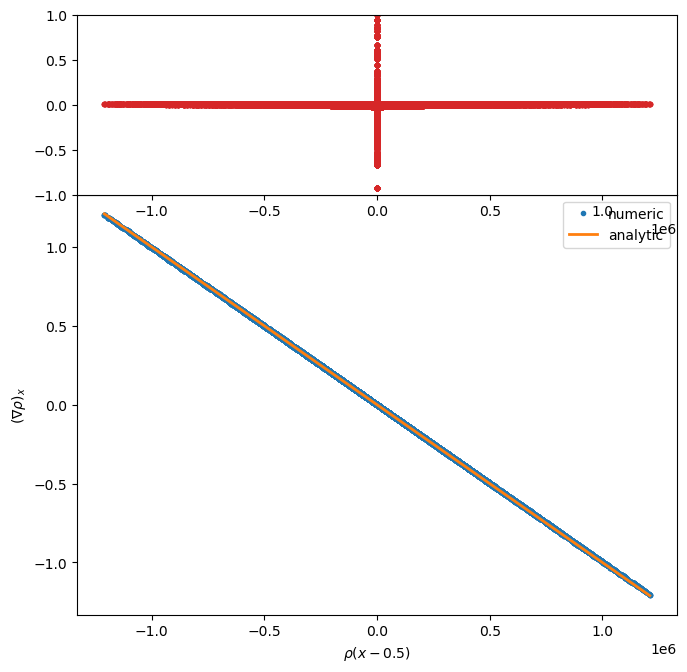

In [183]:
fig = plt.figure(figsize=(6, 6))

ax1 = fig.add_axes([0,0,1,0.7])  
ax2 = fig.add_axes([0,0.7,1,0.3])

sigma = 0.001
rho_xm0p5 = (grid.rho * (grid.x - 0.5))[grid.flag_leaf == 1]
ax1.plot(rho_xm0p5, grid.rho_grad_x[grid.flag_leaf == 1], '.', label='numeric')

x_space = np.linspace(np.min(rho_xm0p5), np.max(rho_xm0p5))
ax1.plot(x_space, -x_space / sigma, lw=2, label='analytic')

ax1.set_xlabel(r"$\rho (x - 0.5)$")
ax1.set_ylabel(r"$(\nabla \rho)_x$")
ax1.legend()  

res = (grid.rho_grad_x[grid.flag_leaf == 1] + rho_xm0p5 / sigma) / (rho_xm0p5 / sigma)
ax2.plot(rho_xm0p5, res, '.', color='C3')
ax2.set_ylim(-1, 1)


In [187]:
np.mean(res[np.abs(rho_xm0p5) > 0.01])

-0.014569993526362256

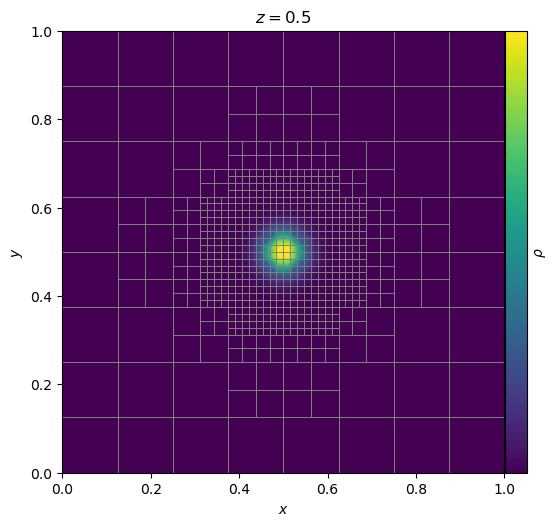

In [89]:
fig = plt.figure(figsize=(6, 6))

z = 0.5
plot_grid_slice(z, color='grey')
x_grid, y_grid, rho_grid = get_var_slice(z, grid.rho)
im = plt.contourf(x_grid, y_grid, rho_grid, levels=200)

plt.gca().set_aspect(1.)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'$z = %.3g$' % z)

cbar_ticks = []
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.01)
plt.colorbar(im, cax=cax, ticks=cbar_ticks, label=r"$\rho$")

# save_fig('grid')


Saved figure


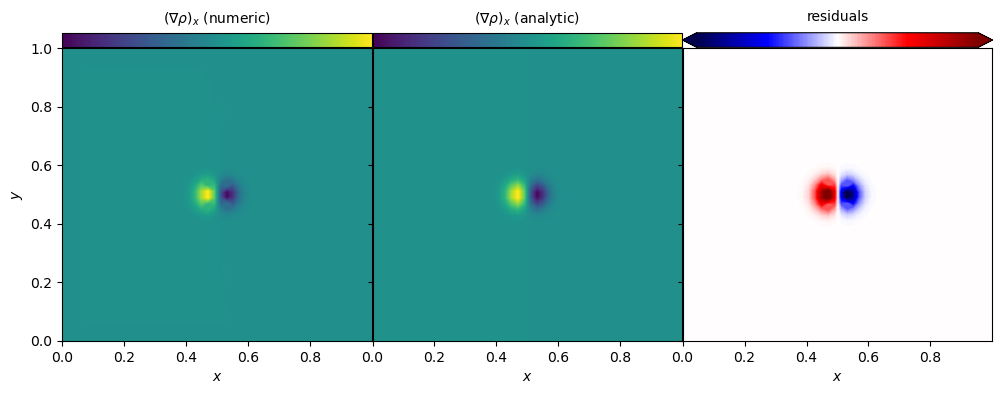

In [180]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), sharex=True, sharey=True)
plt.subplots_adjust(hspace=1e-3, wspace=1e-3)

z = 0.5
num = 100
sigma = 0.001

x_grid, y_grid, rho_slice = get_var_slice(z, grid.rho)
x_grid, y_grid, rho_grad_slice = get_var_slice(z, grid.rho_grad_x)

im1 = axs[0].contourf(x_grid, y_grid, rho_grad_slice, levels=200)
rho_analytic = rho_func(x_grid, y_grid, z)

rho_grad_analytic = -rho_analytic / sigma * (x_grid - 0.5)
im2 = axs[1].contourf(x_grid, y_grid, rho_grad_analytic, levels=200)

res = (rho_grad_slice - rho_grad_analytic)
im3 = axs[2].contourf(x_grid, y_grid, res, levels=np.linspace(-1e9, 1e9, 200), cmap='seismic', extend='both')

for i, (ax, title, im) in enumerate(zip(axs, [r"$(\nabla \rho)_x$ (numeric)", r"$(\nabla \rho)_x$ (analytic)", "residuals"], [im1, im2, im3])):
    cbar_ticks = []
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("top", size="5%", pad=0.01)
    cbar = plt.colorbar(im, cax=cax, ticks=cbar_ticks, orientation='horizontal')
    cbar.set_label(title, labelpad=-27)

axs[0].set_xlabel(r'$x$')
axs[1].set_xlabel(r'$x$')
axs[2].set_xlabel(r'$x$')
axs[0].set_ylabel(r'$y$')

axs[0].set_xticks([0, 0.2, 0.4, 0.6, 0.8])
axs[1].set_xticks([0, 0.2, 0.4, 0.6, 0.8])
axs[2].set_xticks([0, 0.2, 0.4, 0.6, 0.8])

save_fig('residuals')


In [182]:
np.mean(res)

7730.897929654694

Text(0, 0.5, '$N_{\\rm cells}$')

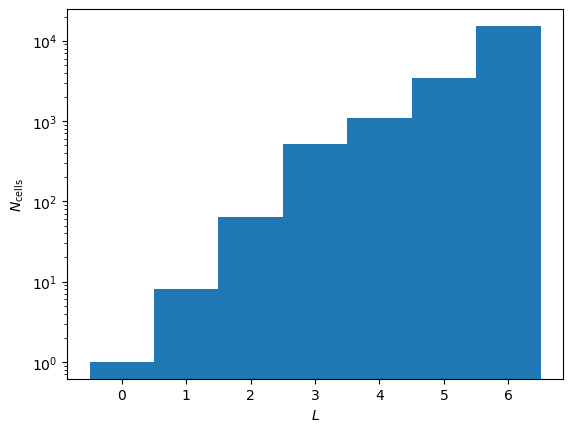

In [173]:
plt.hist(grid.L, bins=np.arange(-0.5, 7))

plt.yscale('log')
plt.xlabel(r'$L$')
plt.ylabel(r'$N_{\rm cells}$')

Text(0, 0.5, 'runtime [${\\rm \\mu s}$]')

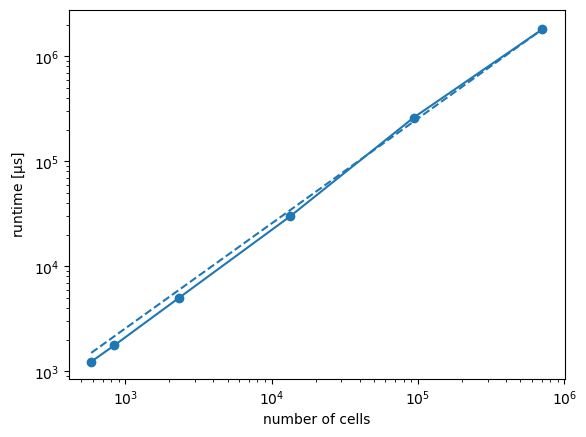

In [177]:
from scipy.optimize import curve_fit

# runtime in microseconds
runtime_L3 = np.array([1235, 1234, 1241, 1241, 1203, 1202, 1234, 1260, 1241, 1241])
runtime_L4 = np.array([1752, 1751, 1759, 1762, 1752, 1751, 1749, 1751, 1855, 1751])
runtime_L5 = np.array([4952, 4950, 4965, 5015, 4956, 4999, 4954, 4960, 4958, 4960])
runtime_L6 = np.array([29481, 29616, 29577, 29780, 30692, 29621, 29721, 30004, 30117, 30327])
runtime_L7 = np.array([264361, 250113, 249122, 255123, 272375, 258727, 268545, 249543, 265019, 273640])
runtime_L8 = np.array([1736153, 1722006, 1676135, 1696274, 1711101, 1739918, 2019275, 1766064, 1927803, 2029346])
runtime_all = np.array([runtime_L3, runtime_L4, runtime_L5, runtime_L6, runtime_L7, runtime_L8])
runtime_avg = np.mean(runtime_all, axis=1)
runtime_std = np.std(runtime_all, axis=1)

L = np.array([3, 4, 5, 6, 7, 8])
num_cells = np.array([585, 841, 2313, 13385, 93449, 705865])

line = lambda x, a: a * x
popt, _ = curve_fit(line, num_cells, runtime_avg)

plt.errorbar(num_cells, runtime_avg, linestyle='-', marker='o', yerr=runtime_std)
plt.plot(num_cells, line(num_cells, *popt), linestyle='--', color='C0')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('number of cells')
plt.ylabel(r'runtime [${\rm \mu s}$]')


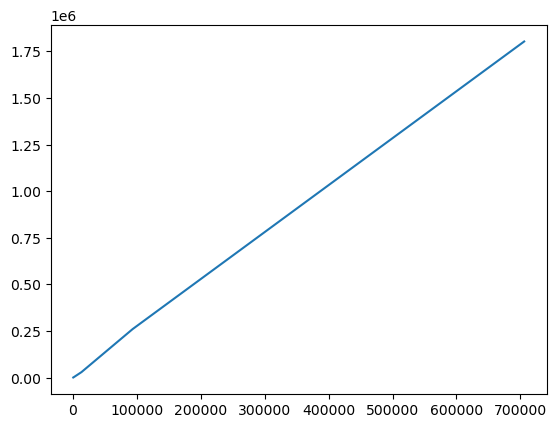

In [176]:
plt.(num_cells, runtime_avg, )


